# Notebook to analyze some Programming Language Info

Here some facts about the programming languages used by Stack Overflow users 2015 will be extracted:
## First import all necessary libraries:
        

In [ ]:
# a look at the data
import sys as ys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from collections import defaultdict
import seaborn as sns
%matplotlib inline


In [127]:

#df = pd.read_csv('survey_results_public.csv')
#shorter extract of data for debug purposes
df = pd.read_csv('c.csv')
schema = pd.read_csv('survey_results_schema.csv')

df.head(3)


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN


## Subroutine Collection

### Subroutine to measure the difference between set and wish of prog. lang. 

here a 34 dim space is introduced, each base vector is representing a programming language.
Thus, C e.g. is [1,0,0,0......0], c++ is [0,1,0,0,0,....].
Each 3 or 4 languages mentioned in the HaveWorkedLanguage or WantWork-Language column represent a special vector in this space. The entries for these languages are 1, all other are zero.

The dot product describes the projection of such an hypervector on another of these, and is a crude measure of 
'difference' between these statements. 

0 means no single fit between languages used and languages keen to be used,
1 means complete fit between languages used and languages keen to be used,

The subroutine below takes care of transfering the statements to this simple metric.

In [128]:

mapper = {
    "JavaScript":  0,     "Python":  1,     "SQL":  2,     "C#":  3,     "Java":  4,     "C++":  5,     "TypeScript":  6,     "Go":  7, 
    "PHP":  8,     "Swift":  9,     "C":  10,     "Ruby":  11,     "Scala":  12,     "Rust":  13,     "R":  14,     "F#":  15, 
    "Haskell":  16,     "Objective-C": 17,    "Elixir":  18,     "Assembly":  19,     "Clojure":  20,     "Erlang":  21,     "Perl":  22,     "CoffeeScript":     23, 
    "Lua":  24,     "Groovy":  25,     "Matlab":  26,     "VB.NET":  27,     "Common Lisp":      28,    "Julia":  29,     "Dart":  30,     "Smalltalk":  31, 
    "VBA":  32,     "Hack":  33,     "Visual Basic 6":  34
}

def createVectorFromList(mapobj, entry1, entry2):
    '''
    INPUT:
    mapobj - dictionary of list position of programming language name
    entry1 - ; separated list of prog.-lang.-names
    entry2 - ; separated list of prog.-lang.-names
    OUTPUT:
    float value 0..1 characterising the geometrical similarity of the language lists in a 34 dim space.
    This value is independent of sequence
    '''
    r1 = list(0 for _ in range(len(mapobj)))
    r2 = list(0 for _ in range(len(mapobj)))
    l1 = str.split(entry1,sep='; ')
    l2 = str.split(entry2,sep='; ')
    for k in l1:
        r1[mapobj[k]] = 1
    for k in l2:
        r2[mapobj[k]] = 1
    
    m_a = m.sqrt(pd.Series(r1).dot(pd.Series(r1))) 
    m_b = m.sqrt(pd.Series(r2).dot(pd.Series(r2))) 
    metric = pd.Series(r1).dot(pd.Series(r2))/m_a/m_b
    return metric


Short Test: 1 0 1/sqrt(2)

In [129]:
u = createVectorFromList(mapper,'Python; C; C#','Python; C; C#')
print(u)
u = createVectorFromList(mapper,'Python; C; C#','Matlab; Haskell')
print(u)
u = createVectorFromList(mapper,'Python; C; C#; Go','Python; C')
print(u)

1.0000000000000002
0.0
0.7071067811865475


### 2 small helpers to drop NaN and calculate measure between 2 cols

In [130]:

def cleansData(df):
    print("-----------------------")
    df = df.dropna(axis=0, subset=['HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction'])
    df.reset_index(drop=True, inplace=True)
    return df

def calcWeight(df):
    for index, row in df.iterrows():
        u = createVectorFromList(mapper, row['HaveWorkedLanguage'], row['WantWorkLanguage'])
        df.loc[index, 'Weight']= u
    return df


### One-Column-Exploder

This subroutine will explode the ; separated entries into a row for each substring, keeping the other records unharmed.
After using this, One can create a value-count frequency analysis of the different languages. 

In [131]:
def createDFwithExplodedLanguage(adf,col):
    df = adf.copy()
    s = df[col].str.split('; ').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with xdf's index
    s.name = col # needs a name to join
    del df[col]
    return df.join(s)



## Reduce the dataset to the only used columns for the analysis to come

In [132]:
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

print("here i slice it")

xdf = df.loc[:,('Respondent','HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction', 'Professional')]
#udf = df.loc[:,('Respondent','HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction', 'Professional')]
#udf = udf.dropna(axis=0, subset=['HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction'])
#udf.reset_index(drop=True, inplace=True)

xdf = cleansData(xdf)
xdf = calcWeight(xdf)

#udf = cleansData(udf)
#udf = calcWeight(udf)

print( xdf.head())



here i slice it
-----------------------
   Respondent                                 HaveWorkedLanguage  \
0           3                                  Java; PHP; Python   
1           4                             Matlab; Python; R; SQL   
2           7                                     Matlab; Python   
3           8  CoffeeScript; Clojure; Elixir; Erlang; Haskell...   
4           9                                     C#; JavaScript   

                            WantWorkLanguage  JobSatisfaction  \
0                            C; Python; Rust              9.0   
1                     Matlab; Python; R; SQL              3.0   
2  JavaScript; Julia; Matlab; Python; R; SQL              6.0   
3            Clojure; Elixir; Haskell; Scala              7.0   
4                                     F#; Go              6.0   

                                        Professional    Weight  
0                             Professional developer  0.333333  
1  Professional non-developer 

### Now the simple statistics for usage of languages

In [133]:
def createDFwithExplodedLanguage(adf,col):
    df = adf.copy()
    s = df[col].str.split('; ').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with xdf's index
    s.name = col # needs a name to join
    del df[col]
    return df.join(s)



In [134]:
rds = createDFwithExplodedLanguage(xdf,'HaveWorkedLanguage')
languageSet=rds.groupby(['HaveWorkedLanguage']).mean()['JobSatisfaction']
print("----RDS----")
print(rds.head(2))
print("----XDF----")
print(xdf.head(2))
print("===========================================================")

sds = createDFwithExplodedLanguage(xdf,'WantWorkLanguage')
languageWish=sds.groupby(['WantWorkLanguage']).mean()['JobSatisfaction']
print("----SDS----")
print(sds.head(2))
print("----XDF----")
print(xdf.head(2))
print("===========================================================")


----RDS----
   Respondent WantWorkLanguage  JobSatisfaction            Professional  \
0           3  C; Python; Rust              9.0  Professional developer   
0           3  C; Python; Rust              9.0  Professional developer   

     Weight HaveWorkedLanguage  
0  0.333333               Java  
0  0.333333                PHP  
----XDF----
   Respondent      HaveWorkedLanguage        WantWorkLanguage  \
0           3       Java; PHP; Python         C; Python; Rust   
1           4  Matlab; Python; R; SQL  Matlab; Python; R; SQL   

   JobSatisfaction                                       Professional  \
0              9.0                             Professional developer   
1              3.0  Professional non-developer who sometimes write...   

     Weight  
0  0.333333  
1  1.000000  
----SDS----
   Respondent HaveWorkedLanguage  JobSatisfaction            Professional  \
0           3  Java; PHP; Python              9.0  Professional developer   
0           3  Java; PHP; P

In [135]:

print( xdf.head())

   Respondent                                 HaveWorkedLanguage  \
0           3                                  Java; PHP; Python   
1           4                             Matlab; Python; R; SQL   
2           7                                     Matlab; Python   
3           8  CoffeeScript; Clojure; Elixir; Erlang; Haskell...   
4           9                                     C#; JavaScript   

                            WantWorkLanguage  JobSatisfaction  \
0                            C; Python; Rust              9.0   
1                     Matlab; Python; R; SQL              3.0   
2  JavaScript; Julia; Matlab; Python; R; SQL              6.0   
3            Clojure; Elixir; Haskell; Scala              7.0   
4                                     F#; Go              6.0   

                                        Professional    Weight  
0                             Professional developer  0.333333  
1  Professional non-developer who sometimes write...  1.000000  
2  Pr

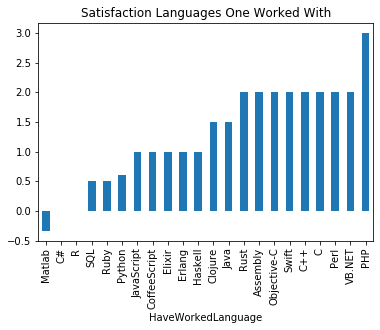

In [136]:
#==========================
# Fun fact evaluation: correlation between JobSatisfaction and Programming Language
# don't mix correlation and causality, as there are 150 more input variables!
#==========================
(languageSet.sort_values()-6).plot(kind="bar");
plt.title("Satisfaction Languages One Worked With");
plt.savefig("kindoflanguages.png")



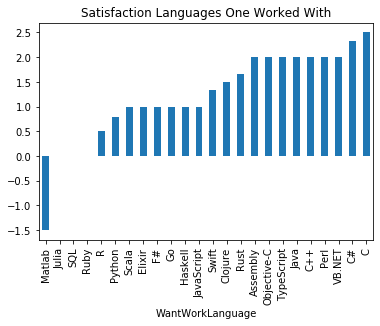

In [137]:
#==========================
# Fun fact evaluation: correlation between JobSatisfaction and 'keen on' Programming Language
# don't mix correlation and causality, as there are 150 more input variables! (not used further)
#==========================
(languageWish.sort_values()-6).plot(kind="bar");
plt.title("Satisfaction Languages One Worked With");
plt.savefig("kindoflanguageswish.png")


## Descriptive Statistics

###  Correlation Analysis of built crude Metric of Discrepancy and Job Satisfaction

   Respondent      HaveWorkedLanguage        WantWorkLanguage  \
0           3       Java; PHP; Python         C; Python; Rust   
1           4  Matlab; Python; R; SQL  Matlab; Python; R; SQL   

   JobSatisfaction                                       Professional  \
0              9.0                             Professional developer   
1              3.0  Professional non-developer who sometimes write...   

     Weight  
0  0.333333  
1  1.000000  


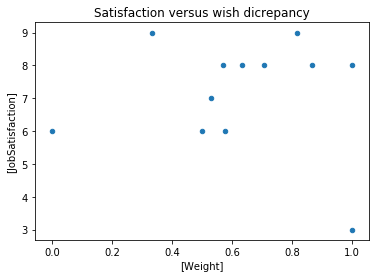

In [140]:
#==========================
# Correlation Analysis of built metric of discrepancy and Job Satisfaction
#==========================
print(xdf.head(2))
xdf.plot.scatter(x=['Weight'], y=['JobSatisfaction'])
plt.title("Satisfaction versus wish dicrepancy");
plt.savefig("kindoflanguagediscrepancy.png")

### Preference of Programming Languages as used nowadays

Assembly        1
C               2
C#              1
C++             1
Clojure         2
CoffeeScript    1
Elixir          1
Erlang          1
Haskell         1
Java            2
Name: HaveWorkedLanguage, dtype: int64


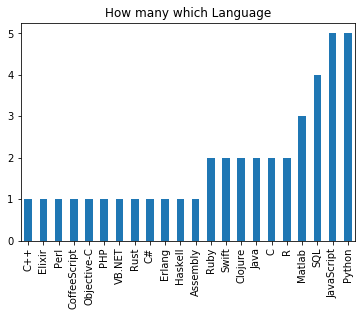

In [142]:
# step by step demo: 
# apply value_counts and sort by language name -- later on for join operation
md = rds['HaveWorkedLanguage'].value_counts().sort_index()
print(md.head(10))

# apply value_counts and sort by value count  -- plot of preference
((rds['HaveWorkedLanguage'].value_counts()).sort_values()).plot(kind="bar");
plt.title("How many which Language");
plt.savefig("kindofcountlang.png")


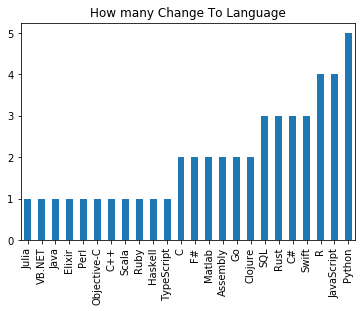

In [144]:
# step by step demo: 
# apply value_counts and sort by language name -- later on for join operation
nd = sds['WantWorkLanguage'].value_counts().sort_index()

# apply value_counts and sort by value count  -- plot of preference
((sds['WantWorkLanguage'].value_counts()).sort_values()).plot(kind="bar");
plt.title("How many Change To Language");
plt.savefig("kindofcountwishlang.png")

### Direct comparision: Join preference vectors, transpose and plot together

        HaveWorkedLanguage  WantWorkLanguage
Perl                   1.0               1.0
Julia                  NaN               1.0
VB.NET                 1.0               1.0
Ruby                   2.0               1.0
Scala                  NaN               1.0


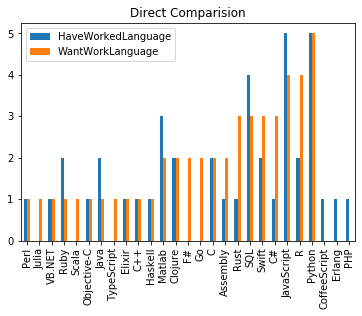

In [146]:
# due to sort_index, the indeizes of md and nd are the same and sorted together -- one common index in dataframe
# then, sort for values of one column to create base of preference plot, and plot the other values over
uf = pd.DataFrame([md,nd]).transpose().sort_values(['WantWorkLanguage'])
print(uf.head(5))

uf.plot(y=['HaveWorkedLanguage',  'WantWorkLanguage'], kind='bar')
plt.title("Direct Comparision");
plt.savefig("kindofcomparision.png")